# Threshold optimization 

Jukes Liu

## Import packages and set paths

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import numpy.ma as ma
import datetime
import math
import scipy.optimize
import time
import random

In [2]:
basepath = '/media/jukes/jukes1/'
sg_path = '/home/jukes/Documents/Sample_glaciers/'

## Read in analysis dates for manual and automated delinations, convert to datetime objs

In [ ]:
#read in manual image dates
manual_df= pd.read_csv(basepath+'Manual/manual_tpos.csv', sep=',', dtype=str, header=0)
manual_df = manual_df.dropna()
manual_df.drop_duplicates(subset=['BoxID','datetimes'])
print(manual_df.shape)
manual_df.head()

In [ ]:
#Read in datetags csv as datetime_df
automated_df = pd.read_csv(sg_path+'imgdates.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
print(automated_df.shape)
automated_df.head()

## Find overlaps and select 90% for training, 10% for testing

In [ ]:
overlap_df = manual_df.merge(automated_df, how='inner', on=['datetimes'])
overlap_df = overlap_df.drop(['Line_x', 'Line_y'], axis=1)
overlap_df = overlap_df.drop_duplicates(['BoxID','datetimes'])
overlap_df = overlap_df.sort_values(by=['BoxID','datetimes'], ascending=True)
overlap_df.shape

In [ ]:
dates = []
for idx, row in overlap_df.iterrows():
    dateID = str(row['BoxID'])+','+str(row['datetimes']+','+str(row['Scene']))
    dates.append(dateID)
# print(date_IDs)

### Select 90% for training

In [ ]:
N = len(dates); print(N)

#pick a random sample of dates for training
train_dates = random.sample(dates, int(N*0.9))
print(len(train_dates))
# print(train_dates)

#grab remaining for testing
test_dates = []
for date in dates:
    if date not in train_dates:
        test_dates.append(date)
print(len(test_dates))
# print(test_dates)

#Check that they don't overlap, should return empty
print(len(train_dates)+len(test_dates)); print(set(train_dates).intersection(test_dates))

In [ ]:
boxes = []; imgdates = []; scenes = []

for td in train_dates:
    BoxID, imgdate, scene = td.split(',')
    boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

train_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
train_df.head()

In [ ]:
#export to csv and text
train_df.to_csv(basepath+'/Manual/train.csv', sep=',', index=False, header=False)
train_df.to_csv(basepath+'/Manual/train.txt', sep=' ', index=False, header=False)

### Grab test dates

In [ ]:
boxes = []; imgdates = []; scenes = []

for td in test_dates:
    BoxID, imgdate, scene = td.split(',')
    boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

test_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
# test_df.head()
#export to csv and text
test_df.to_csv(basepath+'/Manual/test.csv', sep=',', index=False, header=False)
test_df.to_csv(basepath+'/Manual/test.txt', sep=' ', index=False, header=False)

## Define objective function

I'm using a modified version of the L1-norm. Imported from the automated_terminus_functions.py script. The objective funciton will be 1/N * (|Xa-Xm|i) where i=3 (for each centerline 50, 25, 75) and N equals the number of delineations generated (the more the better). The goal then is to minimize the objective function.

In [ ]:
# DOA = '2020_01_20'

# def calc_theta(size_thresh, mod_thresh):
#     #Calculate automated tpos
#     #run terminus_pick.tcl using each of the thresholds
#     terminus_pick = '/home/akhalil/src/xsmurf-2.7/main/xsmurf -nodisplay /home/jukes/Documents/Scripts/terminus_pick.tcl '+str(size_thresh)+' '+str(mod_thresh)
#     print(terminus_pick)
#     subprocess.call(terminus_pick, shell=True)
    
#     #pull automated terminus position from the output
#     #grab each output file
#     differences = []
    
#     for file in os.listdir(sg_path):
#         if DOA in file and file.endswith('csv'):
#             if len(file)>28:
#                 print(file)

#                 #read the output file in and calculate terminus position for each image
#                 #pull automated terminus delineations
#                 auto_tpos = 

#                 #pull in manual tpos 
#                 man_tpos = 

#                 diff = abs(auto_tpos - man_tpos)
#                 differences.append(diff)
    
# #     #return objective function = distance between the two
# #     return np.average(differences)

In [ ]:
# def minimize(size_guess, mod_guess):
#     minimum = scipy.optimize.fmin(center_dist, [size_guess, mod_guess], args=(size_guess, mod_guess),full_output=True)
#     xopt = minimum[0][0]
#     funcval = minimum[1]
#     return xopt, funcval

## Run the optimization using scipy.optimize.fmin()

    scipy.optimize.fmin(func, x0, args=(), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None)[source]

Minimize a function using the downhill simplex algorithm.
This algorithm only uses function values, not derivatives or second derivatives.

Parameters
   - funccallable func(x,*args)
The objective function to be minimized.

   - x0ndarray
Initial guess.

Returns
   - xoptndarray
Parameter that minimizes function.

   - foptfloat
Value of function at minimum: fopt = func(xopt).

   - iterint
Number of iterations performed.

   - funcallsint
Number of function calls made.

   - warnflagint
1 : Maximum number of function evaluations made. 2 : Maximum number of iterations reached.

    -allvecslist
Solution at each iteration.

In [3]:
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import objective_func, calc_theta

In [89]:
base_size_thresh = 0.7; base_mod_thresh = 0.8; thresh_range = 0.15; step=0.05; interval=1000
size_guesses = np.arange(base_size_thresh-thresh_range, base_size_thresh+thresh_range, step)
mod_guesses = np.arange(0.1, 0.8, 0.1)

In [91]:
print(size_guesses); print(mod_guesses);
n_iter = len(size_guesses)*len(mod_guesses)
print(n_iter, 'iterations'); print(n_iter*20/60, "max hours to run")

[0.55 0.6  0.65 0.7  0.75 0.8  0.85]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7]
49 iterations
16.333333333333332 max hours to run


### Hard-coded:

In [92]:
import subprocess
import pandas as pd; import numpy as np

BOXIDS = ['001', '002', '120', '174', '259']; 
IDs = " ".join(BOXIDS)

start_time = time.time() #start recording time

slist = []; mlist = []; thetalist = []; runtimes = []; #store run results
for s in size_guesses:
    for m in mod_guesses:
        t0 = time.time() # start recording time for each run
        
        s = float("{0:.3f}".format(s)); m = float("{0:.3f}".format(m)); #make sure precision and format is correct 
        slist.append(s); mlist.append(m); #append the thresholds to a list
        print(s, m)
        
        #run objective function calculation
        theta = objective_func(IDs, s, m); print(theta); thetalist.append(theta)
        
        runtime = time.time() - t0; runtimes.append(runtime) # calculate run time and store
        print("Iteration run time: %s seconds " % runtime) #print run time for each iteration
        
print("Total time elapsed: --- %s seconds ---" % (time.time() - start_time)) #Print total time elapsed

0.55 0.1
33.64963725385887
Iteration run time: 923.9799520969391 seconds 
0.55 0.2
31.077214945102366
Iteration run time: 940.9471015930176 seconds 
0.55 0.3
28.98413585287624
Iteration run time: 934.8033573627472 seconds 
0.55 0.4
27.593989757829256
Iteration run time: 939.936751127243 seconds 
0.55 0.5
26.60805974713161
Iteration run time: 953.4795436859131 seconds 
0.55 0.6
27.006754802215653
Iteration run time: 969.601663351059 seconds 
0.55 0.7
26.16048785647613
Iteration run time: 972.4686081409454 seconds 
0.6 0.1
33.564545024449075
Iteration run time: 952.0283036231995 seconds 
0.6 0.2
31.3369372100173
Iteration run time: 949.0040435791016 seconds 
0.6 0.3
28.424116074880356
Iteration run time: 957.5860786437988 seconds 
0.6 0.4
27.49410480559668
Iteration run time: 968.2543075084686 seconds 
0.6 0.5
26.89951783105196
Iteration run time: 975.0637993812561 seconds 
0.6 0.6
27.026440969136225
Iteration run time: 979.3102931976318 seconds 
0.6 0.7
26.362800686616538
Iteration run 

In [95]:
optimization_df = pd.DataFrame(list(zip(thetalist, slist, mlist, runtimes)), 
                               columns=['Theta', 'Size_thresh', 'mod_thresh', 'run_time'])
optimization_df

,Theta,Size_thresh,mod_thresh,run_time
0,33.649637,0.55,0.1,923.979952
1,31.077215,0.55,0.2,940.947102
2,28.984136,0.55,0.3,934.803357
3,27.593990,0.55,0.4,939.936751
4,26.608060,0.55,0.5,953.479544
5,27.006755,0.55,0.6,969.601663
6,26.160488,0.55,0.7,972.468608
7,33.564545,0.60,0.1,952.028304
8,31.336937,0.60,0.2,949.004044
9,28.424116,0.60,0.3,957.586079


In [96]:
optimization_df[optimization_df['Theta'] == np.min(optimization_df['Theta'])]

,Theta,Size_thresh,mod_thresh,run_time
27,25.98592,0.7,0.7,1019.205076


In [97]:
optimization_df.to_csv(sg_path+'optimizationresults_3.csv', sep=',')

# Visualize results

In [178]:
#plot results
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

%matplotlib notebook

In [175]:
# df1 = pd.read_csv(sg_path+'optimizationresults_3.csv', sep=',')
# df2 = pd.read_csv(sg_path+'optimizationresults_2.csv', sep=',')
# df3 = pd.read_csv(sg_path+'optimizationresults_1.csv', sep=',')
# optimization_df = pd.concat([df1, df2, df3])
optimization_df = pd.read_csv(sg_path+'optimizationresults_all3.csv', sep=',')

In [173]:
# optimization_df.to_csv(sg_path+'optimizationresults_all3.csv', sep=',')

In [176]:
# #plot
# plt.figure(figsize=(12,8)); 
# ax = plt.axes(projection='3d')
# X = optimization_df['Size_thresh']; Y = optimization_df['mod_thresh']; Z = optimization_df['Theta'];
# ax.scatter3D(X, Y, Z, s=25, c=Z, cmap='hot');
# ax.view_init(0, 90)#set angle of view
# ax.set_xlabel('Size threshold', fontsize=15); ax.set_ylabel('Mod threshold', fontsize=15)
# ax.set_zlabel('Misfit', fontsize=15)
# ax.tick_params(axis='both', which='major', labelsize=15)
# plt.show()

In [150]:
x = optimization_df['Size_thresh']
y = optimization_df['mod_thresh']
z = optimization_df['Theta']

<IPython.core.display.Javascript object>


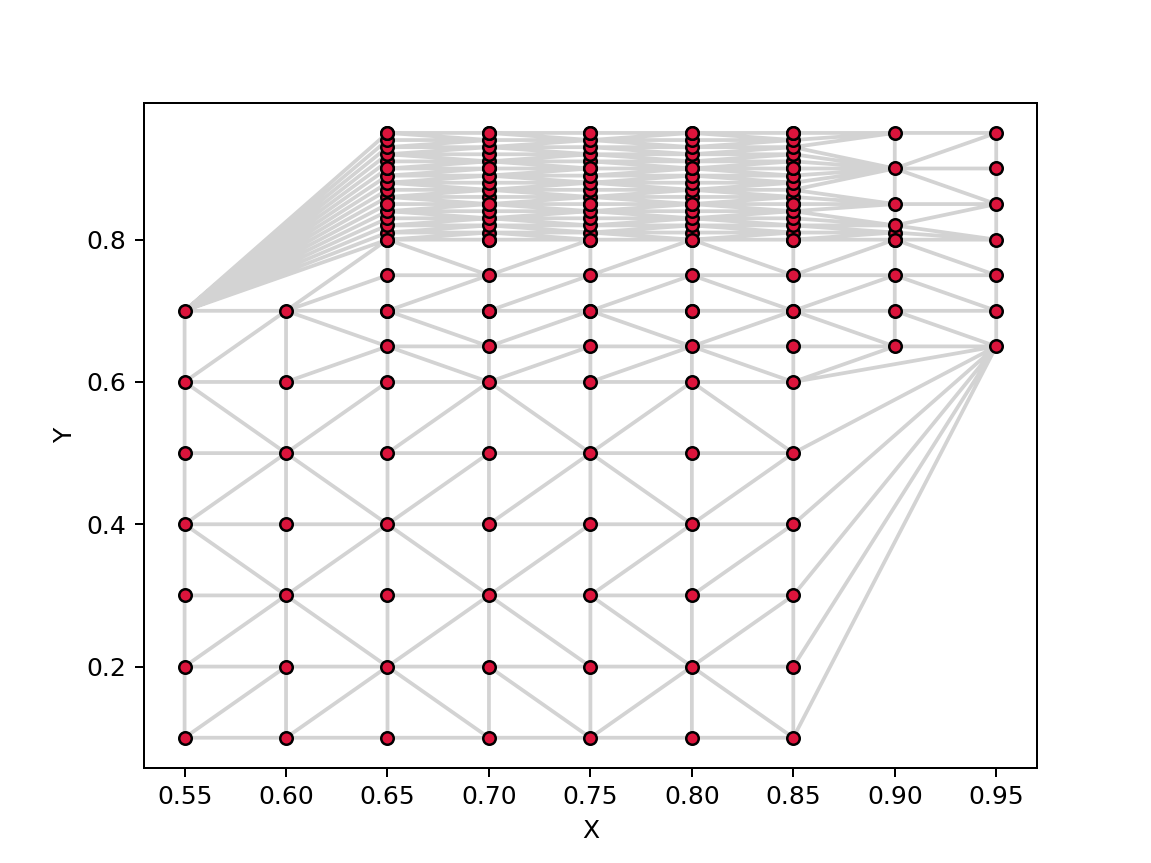

In [179]:
triang = mtri.Triangulation(x, y)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.triplot(triang, c="#D3D3D3", marker='.', markerfacecolor="#DC143C", markeredgecolor="black", markersize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

<IPython.core.display.Javascript object>


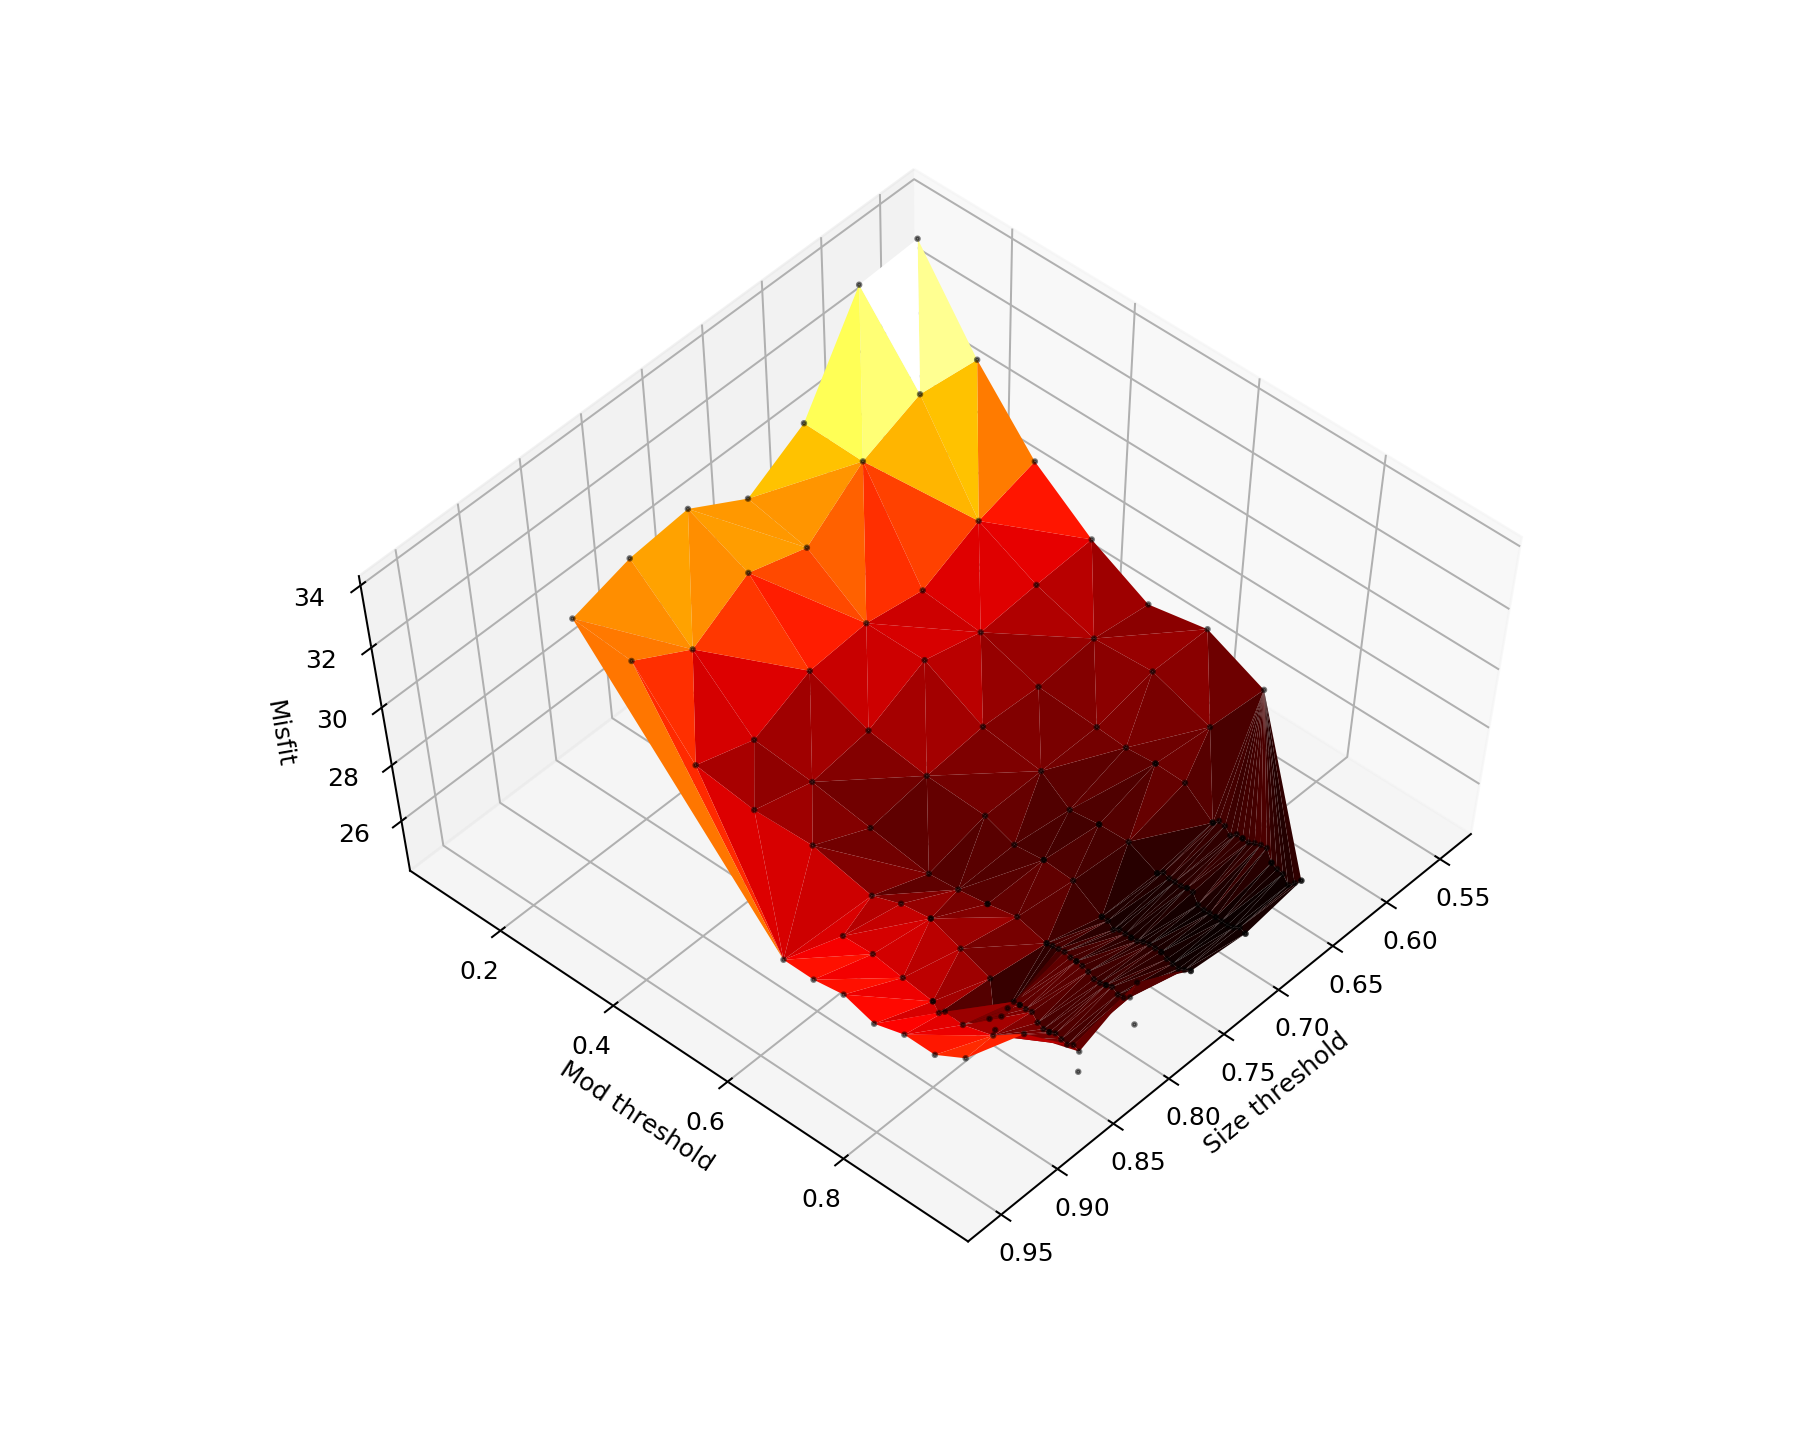

In [182]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_trisurf(triang, z, cmap='hot')
ax.scatter(x,y,z, marker='.', s=10, c="black", alpha=0.5)
ax.view_init(elev=20, azim=45)

ax.set_xlabel('Size threshold')
ax.set_ylabel('Mod threshold')
ax.set_zlabel('Misfit')
plt.show()

## Cross-validation